In [1]:
# Import all dependencies
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix,roc_curve, precision_recall_curve,classification_report
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import math
import sklearn.neighbors._base
import sys
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base
!pip install missingpy
from missingpy import MissForest
import warnings
warnings.filterwarnings("ignore")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 KB 1.4 MB/s eta 0:00:00


# **Loading Dataset** 

In [2]:
# Load the data from the excel  file
data=pd.read_excel('data.xlsx', sheet_name="Base")

# **Extract Information from dataset**

In [3]:
print('Shape of Dataset: ', data.shape)
# remove duplicates 
data.drop_duplicates(inplace=True)
print('Shape of Dataset after removing duplicates: ', data.shape)
# Extract only the cross-selling campagin data
df_sc1=data[data['Account Source']=='Cross-sell'].drop('Account Source',axis=1).reset_index(drop=True)
print('Customers targeted via cross-sell campaign: ', df_sc1.shape)
print('Missing recods per feature\n', df_sc1.isnull().sum())
# Dataset preview
df=df_sc1.copy()
df.head(5)

Shape of Dataset:  (40769, 10)
Shape of Dataset after removing duplicates:  (35903, 10)
Customers targeted via cross-sell campaign:  (8182, 9)
Missing recods per feature
 AccountID                 6283
Billing State/Province    2331
Credit Limit               389
Credit Score               374
Employees                   95
Industry                   333
Total Fleet Size             0
Product B Customer        6283
Status                    6283
dtype: int64


,AccountID,Billing State/Province,Credit Limit,Credit Score,Employees,Industry,Total Fleet Size,Product B Customer,Status
0,NaN,LANCASHIRE,630000.0,100.0,163.0,Manufacturing,17,NaN,NaN
1,ebde18f4cfee824d302509d93699c866a759d443675864...,NaN,53000.0,90.0,15.0,Manufacturing,27,1.0,Awaiting Cancel
2,NaN,CAMBRIDGESHIRE,400000.0,89.0,1.0,Service Industries,30,NaN,NaN
3,ad108a9d7c4176705444f39205dde50bafbecd109f6aad...,NaN,450000.0,92.0,31.0,Wholesale,0,1.0,Active
4,NaN,NORFOLK,1200000.0,100.0,90.0,"Financial, Insurance",2,NaN,NaN


In [4]:
print('No. of customers having records only for "AccountID" or "Status":'\
      , len(df[(df['AccountID'].isnull()) & (~df['Status'].isnull())]))
print('No. of records hsving null values in both "Credit Limit" and "Credit Score" columns: ',len(df[(df['Credit Limit'].isnull()) & (df['Credit Score'].isnull())]))
print('\nTotal unique values for column "Status" (with NAN): ',len(df['Status'].unique()),'\nCount of unique values:\n', df['Status'].value_counts())
print('\nTotal unique values for column "Industry" (with NAN): ',len(df['Industry'].unique()),'\nCount of unique values:\n', df['Industry'].value_counts())
print('\nTotal unique values for column "Billing State/Province" (with NAN): ',len(df['Billing State/Province'].unique()),'\nCount of unique values:\n', df['Billing State/Province'].value_counts())

No. of customers having records only for "AccountID" or "Status": 0
No. of records hsving null values in both "Credit Limit" and "Credit Score" columns:  370

Total unique values for column "Status" (with NAN):  4 
Count of unique values:
 Active             979
Awaiting Cancel    822
Frozen              98
Name: Status, dtype: int64

Total unique values for column "Industry" (with NAN):  13 
Count of unique values:
 Service Industries                 2006
Manufacturing                      1722
Construction                       1444
Retail                              853
Wholesale                           684
Transportations, Communications     474
Financial, Insurance                356
Agriculture, Forestry, Fishing      159
Public Administration                70
Unknown                              49
Mining                               26
CONSTRUCTION                          6
Name: Industry, dtype: int64

Total unique values for column "Billing State/Province" (with NAN):  

# **Filling Missing Values**

### **1.   Categorical variables**

In [5]:
# Filling the missing values
"""Product B Customer: 1-Purchased Product B, 0- Did not Purchased Product B, target variable
  Billing State/Province: Region name, can be label encoded
  Status: Product B account status (Active, Frozen, Awaiting Cancel), can be one hot encoded"""
df['Product B Customer'].fillna(0, inplace=True)
df['Billing State/Province'].fillna('Missing', inplace=True)
# Label Encode the region column
le = LabelEncoder()
df['Billing State/Province'] = le.fit_transform(df['Billing State/Province'])
# Merge the 2 sub categories
df['Industry'].replace('CONSTRUCTION', 'Construction', inplace=True)
# One hot encode the rest of the categorical columns
df= pd.concat([df, pd.get_dummies(df['Status']),pd.get_dummies(df['Industry'])], axis=1) 
print('DataFrame Columns:\n',df.columns)
df.head()

DataFrame Columns:
 Index(['AccountID', 'Billing State/Province', 'Credit Limit', 'Credit Score',
       'Employees', 'Industry', 'Total Fleet Size', 'Product B Customer',
       'Status', 'Active', 'Awaiting Cancel', 'Frozen',
       'Agriculture, Forestry, Fishing', 'Construction',
       'Financial, Insurance', 'Manufacturing', 'Mining',
       'Public Administration', 'Retail', 'Service Industries',
       'Transportations, Communications', 'Unknown', 'Wholesale'],
      dtype='object')


,AccountID,Billing State/Province,Credit Limit,Credit Score,Employees,Industry,Total Fleet Size,Product B Customer,Status,Active,...,Construction,"Financial, Insurance",Manufacturing,Mining,Public Administration,Retail,Service Industries,"Transportations, Communications",Unknown,Wholesale
0,NaN,131,630000.0,100.0,163.0,Manufacturing,17,0.0,NaN,0,...,0,0,1,0,0,0,0,0,0,0
1,ebde18f4cfee824d302509d93699c866a759d443675864...,155,53000.0,90.0,15.0,Manufacturing,27,1.0,Awaiting Cancel,0,...,0,0,1,0,0,0,0,0,0,0
2,NaN,31,400000.0,89.0,1.0,Service Industries,30,0.0,NaN,0,...,0,0,0,0,0,0,1,0,0,0
3,ad108a9d7c4176705444f39205dde50bafbecd109f6aad...,155,450000.0,92.0,31.0,Wholesale,0,1.0,Active,1,...,0,0,0,0,0,0,0,0,0,1
4,NaN,157,1200000.0,100.0,90.0,"Financial, Insurance",2,0.0,NaN,0,...,0,1,0,0,0,0,0,0,0,0


### **2. Numerical variables**

In [6]:
df.reset_index(drop=True, inplace=True)
# Remove the redundant columns
df_impute=df.drop(['AccountID','Status','Industry'], axis=1)
# Use missforest to impute rest of the features
imputer=MissForest(max_iter=5)
df_imputed=pd.DataFrame(imputer.fit_transform(df_impute),columns=df_impute.columns)
df_imputed

Iteration: 0
Iteration: 1
Iteration: 2


,Billing State/Province,Credit Limit,Credit Score,Employees,Total Fleet Size,Product B Customer,Active,Awaiting Cancel,Frozen,"Agriculture, Forestry, Fishing",Construction,"Financial, Insurance",Manufacturing,Mining,Public Administration,Retail,Service Industries,"Transportations, Communications",Unknown,Wholesale
0,131.0,630000.0,100.00,163.0,17.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,155.0,53000.0,90.00,15.0,27.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,31.0,400000.0,89.00,1.0,30.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,155.0,450000.0,92.00,31.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,157.0,1200000.0,100.00,90.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8177,155.0,86904.0,91.96,16.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8178,155.0,44450.0,93.56,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8179,155.0,60856.0,55.01,45.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8180,155.0,87000.0,100.00,36.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
# Add "status" and "industry" features in DataFrame and impute the NaN values with str "Canceled" and "Missing", respectively.
df_imputed=pd.concat([df_imputed, df['Status'],df['Industry']], axis=1)
df_imputed['Status'].fillna('Canceled', inplace=True)
df_imputed['Industry'].fillna('Missing', inplace=True)
df_imputed.head(5)

,Billing State/Province,Credit Limit,Credit Score,Employees,Total Fleet Size,Product B Customer,Active,Awaiting Cancel,Frozen,"Agriculture, Forestry, Fishing",...,Manufacturing,Mining,Public Administration,Retail,Service Industries,"Transportations, Communications",Unknown,Wholesale,Status,Industry
0,131.0,630000.0,100.0,163.0,17.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Canceled,Manufacturing
1,155.0,53000.0,90.0,15.0,27.0,1.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Awaiting Cancel,Manufacturing
2,31.0,400000.0,89.0,1.0,30.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,Canceled,Service Industries
3,155.0,450000.0,92.0,31.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Active,Wholesale
4,157.0,1200000.0,100.0,90.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Canceled,"Financial, Insurance"


In [24]:
df_imputed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8182 entries, 0 to 8181
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Billing State/Province           8182 non-null   float64
 1   Credit Limit                     8182 non-null   float64
 2   Credit Score                     8182 non-null   float64
 3   Employees                        8182 non-null   float64
 4   Total Fleet Size                 8182 non-null   float64
 5   Product B Customer               8182 non-null   float64
 6   Active                           8182 non-null   float64
 7   Awaiting Cancel                  8182 non-null   float64
 8   Frozen                           8182 non-null   float64
 9   Agriculture, Forestry, Fishing   8182 non-null   float64
 10  Construction                     8182 non-null   float64
 11  Financial, Insurance             8182 non-null   float64
 12  Manufacturing       

# **Data Visualisation**

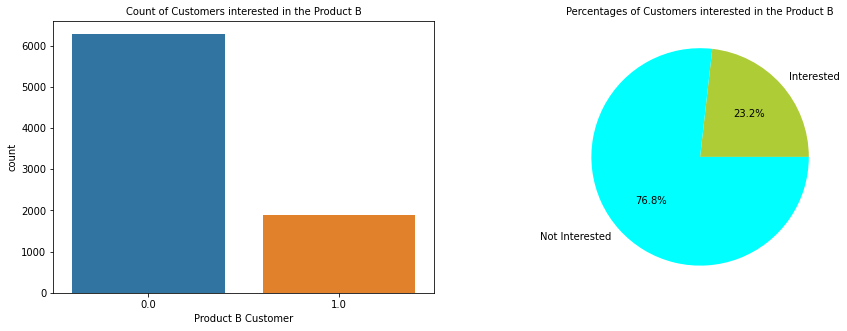

In [9]:
# Find percent of customer buy and not buy the Product B
positive_percent = len(df_imputed[df_imputed['Product B Customer'] == 1])/len(df_imputed)*100 
negative_percent = len(df_imputed[df_imputed['Product B Customer'] == 0])/len(df_imputed)*100
percentages = [positive_percent,negative_percent]

# Visualize Product B purchase using subplot
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.countplot(df_imputed['Product B Customer'],ax=axes[0])
axes[0].set_title('Count of Customers interested in the Product B', fontsize = 10)
axes[1].pie(percentages, labels=['Interested','Not Interested'], autopct = '%.1f%%', colors = ['#aecc35', 'cyan'])
axes[1].set_title('Percentages of Customers interested in the Product B', fontsize = 10)
plt.show()


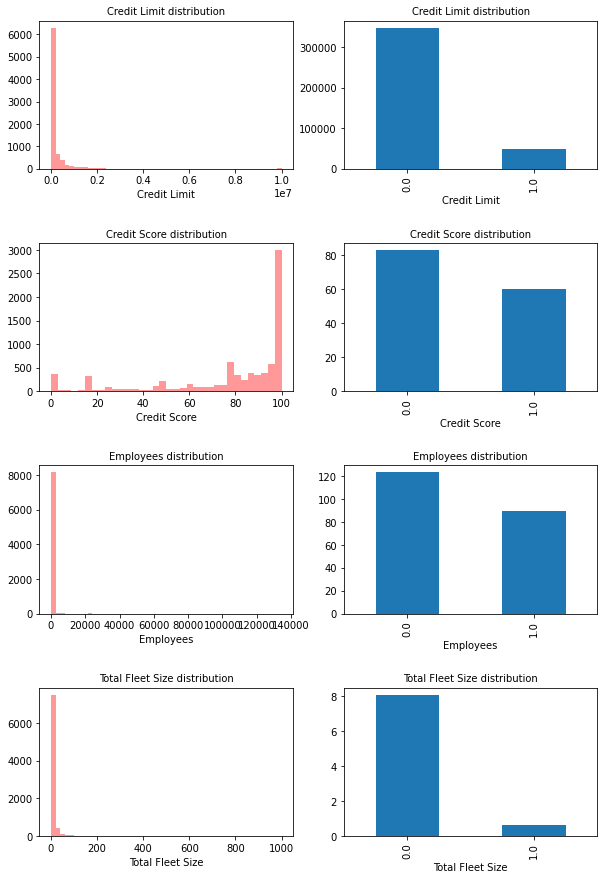

In [10]:
# Visualize the key numerical features along with their mean distribution in purchasing of Product B
num_col=['Credit Limit','Credit Score','Employees','Total Fleet Size']
fig, axes = plt.subplots(len(num_col), 2, figsize=(10, 15))
fig.subplots_adjust(hspace=.5)
target_col='Product B Customer'
for idx, col in enumerate(num_col):
  # Plot the main feature
  sns.distplot(df_imputed[col], kde = False, color = 'Red',ax=axes[idx,0])
  axes[idx,0].set_xlabel(col, fontsize = 10)
  axes[idx,0].set_title('{} distribution'.format(col), fontsize = 10)
  # plot of feature mean aggregated on the target variable 
  df_imputed.groupby(target_col)[col].mean().plot.bar(ax=axes[idx,1])
  axes[idx,1].set_xlabel(col, fontsize = 10)
  axes[idx,1].set_title('{} distribution'.format(col), fontsize = 10)
plt.show()

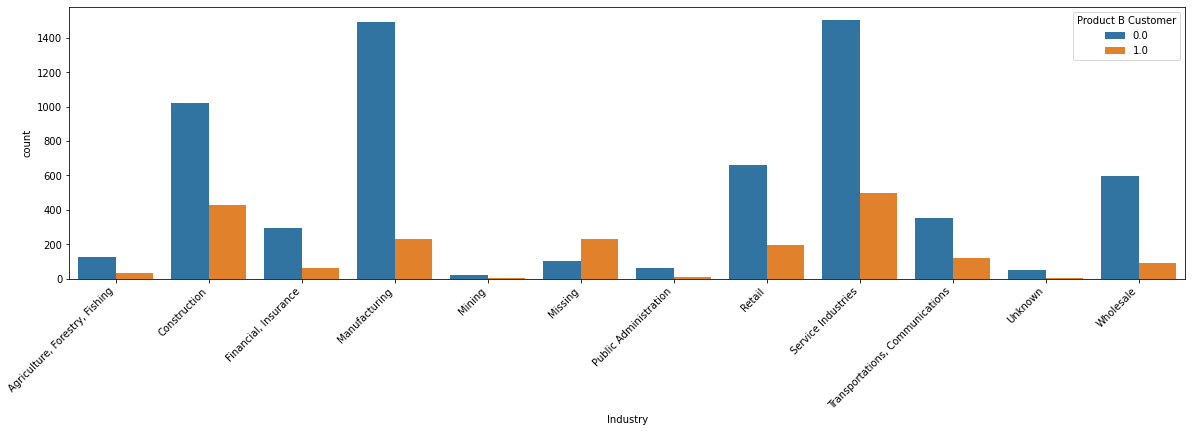

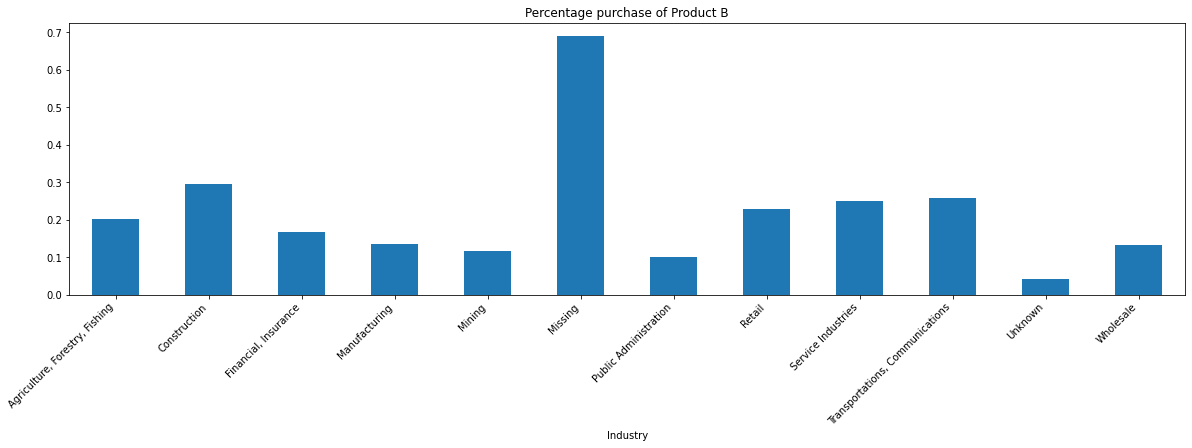

In [11]:
# Visualize the purchase count of Product B based on the subcategories of industry
plt.figure(figsize=(20, 5))
sns.countplot(data=df_imputed, x=df_imputed['Industry'].sort_values(), hue=target_col)
plt.xticks(rotation=45, ha='right')

# Visualize the percent purchase of Product B based on the subcategories of industry
plt.figure(figsize=(20, 5))
df_imputed.groupby('Industry')[target_col].mean().plot.bar()
plt.title('Percentage purchase of Product B')
plt.xticks(rotation=45, ha='right')
plt.show()

# **Feature Transformation**

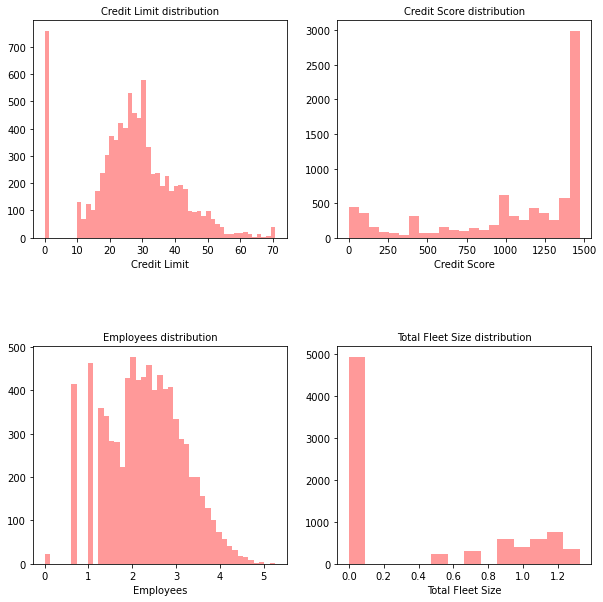

In [12]:
# Visualize the impact of transformation on key numerical features along with their mean distribution in purchasing of Product B
# features selected for transformation
num_col=['Credit Limit','Credit Score','Employees','Total Fleet Size']
# # Initialize the subplot and variables
subplot_cols=2
fig, axes = plt.subplots(math.floor(len(num_col)/subplot_cols), subplot_cols, figsize=(10, 10))
fig.subplots_adjust(hspace=.5)
col_cnt=0
row_cnt=0

for idx, col in enumerate(num_col):
  # Visualize the impact of BoxCox Transformation on feature
  sns.distplot(stats.boxcox(df_imputed[col]+1)[0], kde = False, color = 'Red',ax=axes[row_cnt,col_cnt])
  axes[row_cnt,col_cnt].set_xlabel(col, fontsize = 10)
  axes[row_cnt,col_cnt].set_title('{} distribution'.format(col), fontsize = 10)
  # update the subplot row and col index
  if col_cnt==subplot_cols-1:
    col_cnt=0
    row_cnt=row_cnt+1
  else:
    col_cnt=col_cnt+1
plt.show()

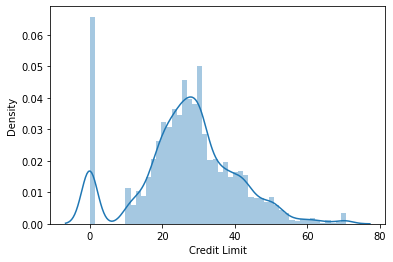

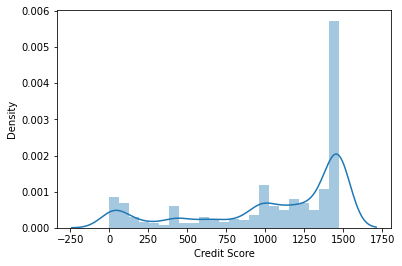

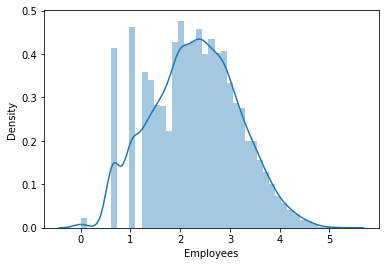

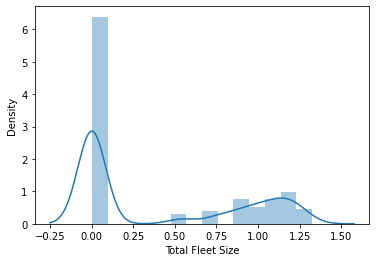

In [13]:
# Perform and save the transformated data
num_col=['Credit Limit','Credit Score','Employees','Total Fleet Size']
for i in num_col:
  df_imputed[i]=stats.boxcox(df_imputed[i]+1)[0]
  sns.distplot(df_imputed[i])
  plt.show()

## **Data Splitting**

In [26]:
X=df_imputed.drop([target_col,'Status', 'Industry'], axis=1)
y=df_imputed[target_col]
skf = StratifiedKFold(n_splits=5,shuffle=True)
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

# **Feature selection**

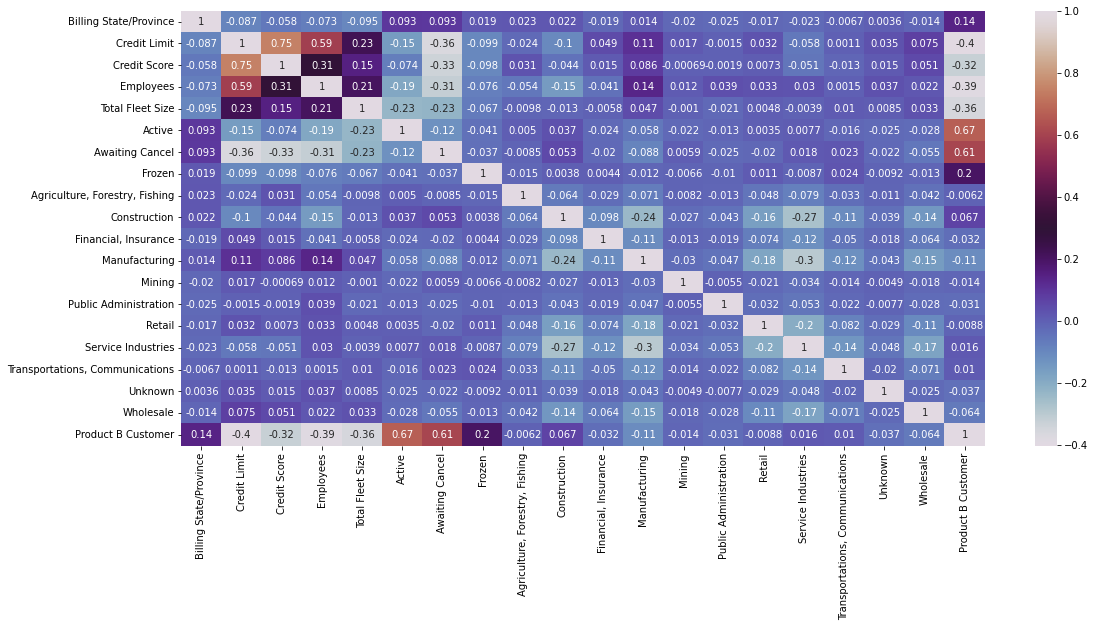

In [27]:
# merge both X_train and y_train in one DataFrame
train_df= pd.concat([X_train, y_train], axis=1)
# Check for the correlation and plot a heatmap
plt.figure(figsize = (18,8))
sns.heatmap(train_df.corr(), cmap = 'twilight', annot = True)
plt.show()

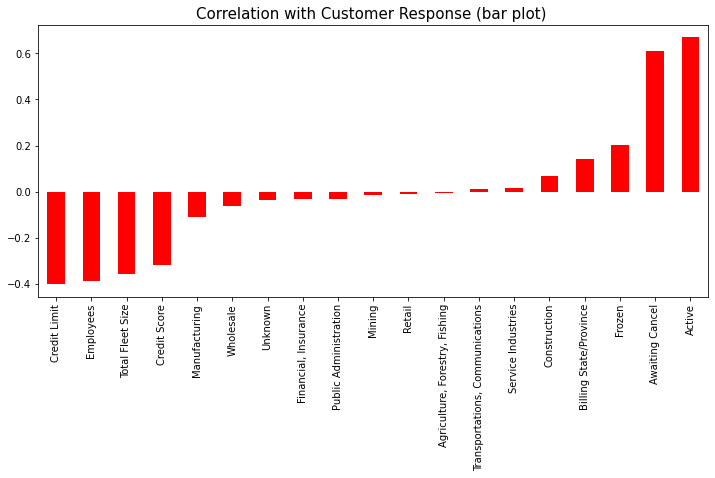

In [28]:
# Visualise the correlation with target variable
plt.figure(figsize=(12,5))
train_df.corrwith(train_df[target_col]).sort_values().drop(target_col).plot(kind='bar', color = 'red')
plt.title('Correlation with Customer Response (bar plot) ', fontsize= 15)
plt.show()

In [29]:
# Extract the features importance
# top 5 important features
top5_feat=abs(train_df.corrwith(train_df[target_col])).sort_values(ascending=False).index[1:6]
# All features sorted with their importance
feat_imp=pd.DataFrame(abs(train_df.corrwith(train_df[target_col])).sort_values(ascending=False), columns=['Correlation with Target'])
feat_imp=feat_imp[1:]
feat_imp

,Correlation with Target
Active,0.670065
Awaiting Cancel,0.608141
Credit Limit,0.402441
Employees,0.387452
Total Fleet Size,0.355530
Credit Score,0.320093
Frozen,0.201066
Billing State/Province,0.142199
Manufacturing,0.110232
Construction,0.067142


# **We can work on 3 different scenarios:**
1.   Using all features
2.   Only take first 5 important features
3.   We had limited or no information about the Product B account status (Means include some or no information of target in dataset):
      (i) Only Active Account info available
     (ii) **No info**: a) Include all other features b) Include top 10 features 
 


In [30]:
# Model scorecard
def score_card(model, x_train, x_test, y_train, y_test):
  """
    Prints and plots the performance metrices for the model
    """
  # Predict the value
  y_train_pred = model.predict(x_train)
  y_test_pred = model.predict(x_test)
  # Predict the probability
  y_train_pred_prob = model.predict_proba(x_train)[:, 1]
  y_test_pred_prob = model.predict_proba(x_test)[:, 1]

  # print the model score card
  print('Model Score Card\n')
  print('Training data set: 80% of the original data set')
  print('Test data set: 20% of the original data set')
  print('Preprocessing techniques: Standard scaling\n')
  print('Training results:\n',classification_report(y_train,y_train_pred))
  print('Test results:\n',classification_report(y_test,y_test_pred))

  # Confusion matrix
  train_cm = confusion_matrix(y_train, y_train_pred)
  test_cm = confusion_matrix(y_test, y_test_pred)
  print('Training Confusion Matrix:\n')
  sns.heatmap(train_cm, annot=True,fmt='g')
  plt.show()
  print('Test Confusion Matrix:\n')
  sns.heatmap(test_cm, annot=True,fmt='g')
  plt.show()
  
  # ROC curve
  print('ROC Curve:\n')
  fpr, tpr, _ = roc_curve(y_train, y_train_pred_prob)
  fpr2, tpr2, _ = roc_curve(y_test, y_test_pred_prob)
  # Calculate roc_auc_score
  roc_auc = roc_auc_score(y_train, y_train_pred_prob)
  roc_auc2 = roc_auc_score(y_test, y_test_pred_prob)
  # plot the ROC curve
  plt.plot(fpr, tpr, label='Training ROC curve (area = %0.2f)' % roc_auc)
  plt.plot(fpr2, tpr2, label='Testing ROC curve (area = %0.2f)' % roc_auc2)
  plt.plot([0, 1], [0, 1], 'k--')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic (ROC) curve')
  plt.legend(loc="lower right")
  plt.show()

  # plot precision-recall curve
  print('Precision-Recall curve:\n')
  precision, recall, _ = precision_recall_curve(y_train, y_train_pred_prob)
  precision2, recall2, _ = precision_recall_curve(y_test, y_test_pred_prob)
  # Calculate the f1 score
  f1_train = f1_score(y_train, y_train_pred)
  f1_test = f1_score(y_test, y_test_pred)
  # plot the Precision-Recall curve
  plt.plot(recall, precision, label='Training Precision-Recall curve (F1-score = %0.2f)' % f1_train)
  plt.plot(recall2, precision2, label='Test Precision-Recall curve (F1-score = %0.2f)' % f1_test)
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.title('Precision-Recall curve')
  plt.legend(loc="lower left")
  plt.show()

# **Scenario 1: Include all features**

Model Score Card

Training data set: 80% of the original data set
Test data set: 20% of the original data set
Preprocessing techniques: Standard scaling

Training results:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      5027
         1.0       1.00      1.00      1.00      1519

    accuracy                           1.00      6546
   macro avg       1.00      1.00      1.00      6546
weighted avg       1.00      1.00      1.00      6546

Test results:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1256
         1.0       1.00      1.00      1.00       380

    accuracy                           1.00      1636
   macro avg       1.00      1.00      1.00      1636
weighted avg       1.00      1.00      1.00      1636

Training Confusion Matrix:



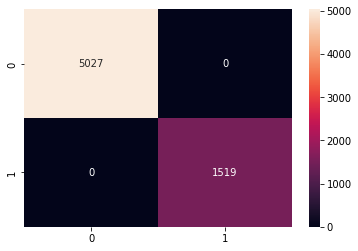

Test Confusion Matrix:



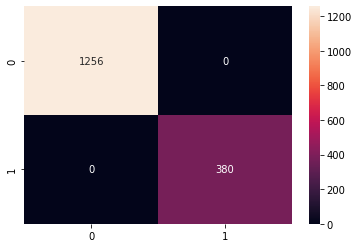

ROC Curve:



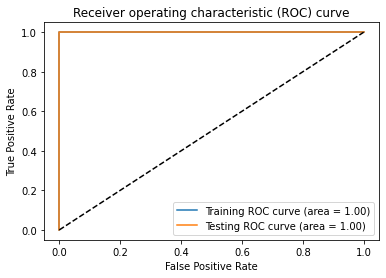

Precision-Recall curve:



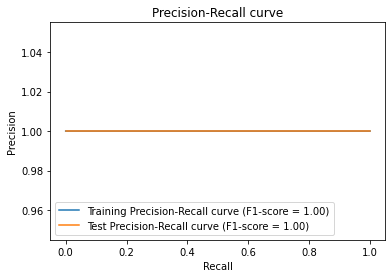

In [31]:
# Use standard scaler to scale the features
scaler=StandardScaler()
x_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
x_test_scaled = pd.DataFrame(scaler.fit_transform(X_test), columns=X_train.columns)

# Build and fit the logistic regression model
model = LogisticRegression()
model.fit(x_train_scaled,y_train)
# print the model scorecard
score_card(model, x_train_scaled, x_test_scaled, y_train, y_test)


# **Scenario 2: Top 5 important features**


Model Score Card

Training data set: 80% of the original data set
Test data set: 20% of the original data set
Preprocessing techniques: Standard scaling

Training results:
               precision    recall  f1-score   support

         0.0       0.98      1.00      0.99      5027
         1.0       1.00      0.95      0.97      1519

    accuracy                           0.99      6546
   macro avg       0.99      0.97      0.98      6546
weighted avg       0.99      0.99      0.99      6546

Test results:
               precision    recall  f1-score   support

         0.0       0.99      1.00      0.99      1256
         1.0       1.00      0.95      0.97       380

    accuracy                           0.99      1636
   macro avg       0.99      0.97      0.98      1636
weighted avg       0.99      0.99      0.99      1636

Training Confusion Matrix:



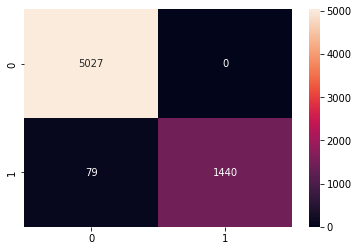

Test Confusion Matrix:



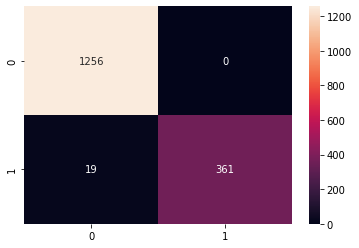

ROC Curve:



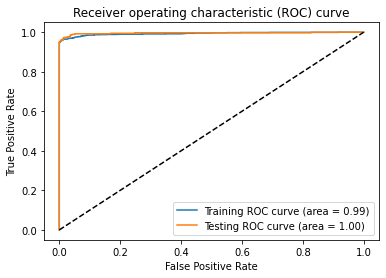

Precision-Recall curve:



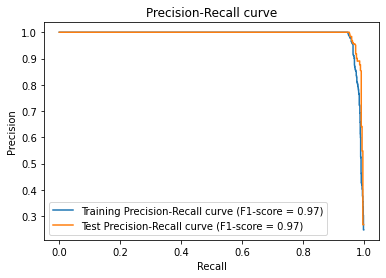

In [32]:
# Use standard scaler to scale the features
scaler=StandardScaler()
# Extract the top 5 features in X_train and X_test
X_train2=X_train[top5_feat]
X_test2=X_test[top5_feat]
# Perform Scaling
x_train_scaled = pd.DataFrame(scaler.fit_transform(X_train2), columns=X_train2.columns)
x_test_scaled = pd.DataFrame(scaler.fit_transform(X_test2), columns=X_train2.columns)

# Build and fit the logistic regression model
model = LogisticRegression()
model.fit(x_train_scaled,y_train)

# print the model scorecard
score_card(model, x_train_scaled, x_test_scaled, y_train, y_test)


# **Scenario *3*: We had limited or no information about the Product B account status**


1.   Only Active Account info available
2.   No info:
     a) Include all other features
     b) Include top 10 features





### **Part A: Only Active Account info available**


Model Score Card

Training data set: 80% of the original data set
Test data set: 20% of the original data set
Preprocessing techniques: Standard scaling

Training results:
               precision    recall  f1-score   support

         0.0       0.93      0.97      0.95      5027
         1.0       0.90      0.77      0.83      1519

    accuracy                           0.93      6546
   macro avg       0.92      0.87      0.89      6546
weighted avg       0.92      0.93      0.92      6546

Test results:
               precision    recall  f1-score   support

         0.0       0.94      0.98      0.96      1256
         1.0       0.91      0.78      0.84       380

    accuracy                           0.93      1636
   macro avg       0.92      0.88      0.90      1636
weighted avg       0.93      0.93      0.93      1636

Training Confusion Matrix:



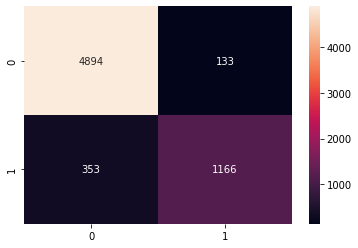

Test Confusion Matrix:



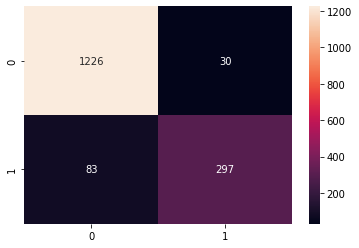

ROC Curve:



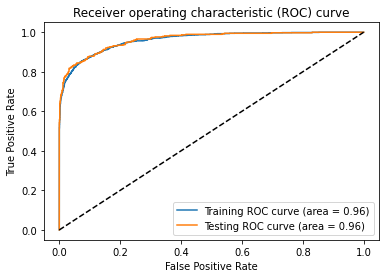

Precision-Recall curve:



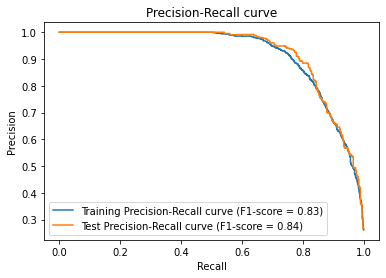

In [33]:
# Use standard scaler to scale the features
scaler=StandardScaler()
# Drop Account info except the Active ones
X_train3=X_train.drop(['Awaiting Cancel','Frozen'],axis=1)
X_test3=X_test.drop(['Awaiting Cancel','Frozen'],axis=1)
# Perform Scaling
x_train_scaled = pd.DataFrame(scaler.fit_transform(X_train3), columns=X_train3.columns)
x_test_scaled = pd.DataFrame(scaler.fit_transform(X_test3), columns=X_train3.columns)

# Build and fit the logistic regression model
model = LogisticRegression()
model.fit(x_train_scaled,y_train)

# print the model scorecard
score_card(model, x_train_scaled, x_test_scaled, y_train, y_test)


### **Part B: No info**

**1.   Include all other features**




Model Score Card

Training data set: 80% of the original data set
Test data set: 20% of the original data set
Preprocessing techniques: Standard scaling

Training results:
               precision    recall  f1-score   support

         0.0       0.87      0.94      0.90      5027
         1.0       0.72      0.53      0.61      1519

    accuracy                           0.84      6546
   macro avg       0.79      0.73      0.76      6546
weighted avg       0.83      0.84      0.83      6546

Test results:
               precision    recall  f1-score   support

         0.0       0.88      0.95      0.91      1256
         1.0       0.77      0.58      0.66       380

    accuracy                           0.86      1636
   macro avg       0.83      0.76      0.79      1636
weighted avg       0.86      0.86      0.86      1636

Training Confusion Matrix:



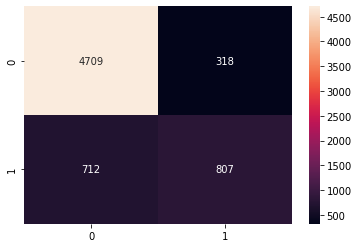

Test Confusion Matrix:



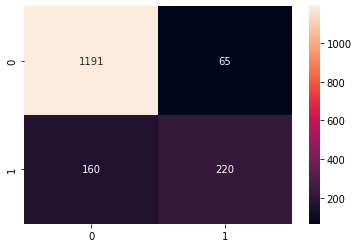

ROC Curve:



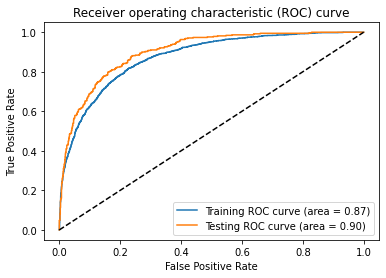

Precision-Recall curve:



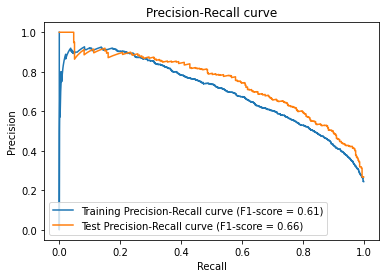

In [34]:
# Use standard scaler to scale the features
scaler=StandardScaler()
# Remove all info regarding the status of Product B account
X_train4=X_train.drop(['Active','Awaiting Cancel','Frozen'],axis=1)
X_test4=X_test.drop(['Active','Awaiting Cancel','Frozen'],axis=1)

# Perform Scaling
x_train_scaled = pd.DataFrame(scaler.fit_transform(X_train4), columns=X_train4.columns)
x_test_scaled = pd.DataFrame(scaler.fit_transform(X_test4), columns=X_train4.columns)

# Build and fit the logistic regression model
model = LogisticRegression()
model.fit(x_train_scaled,y_train)

# print the model scorecard
score_card(model, x_train_scaled, x_test_scaled, y_train, y_test)

**2.   Include top features**



Model Score Card

Training data set: 80% of the original data set
Test data set: 20% of the original data set
Preprocessing techniques: Standard scaling

Training results:
               precision    recall  f1-score   support

         0.0       0.87      0.93      0.90      5027
         1.0       0.70      0.52      0.60      1519

    accuracy                           0.84      6546
   macro avg       0.78      0.73      0.75      6546
weighted avg       0.83      0.84      0.83      6546

Test results:
               precision    recall  f1-score   support

         0.0       0.88      0.94      0.91      1256
         1.0       0.75      0.57      0.64       380

    accuracy                           0.86      1636
   macro avg       0.81      0.75      0.78      1636
weighted avg       0.85      0.86      0.85      1636

Training Confusion Matrix:



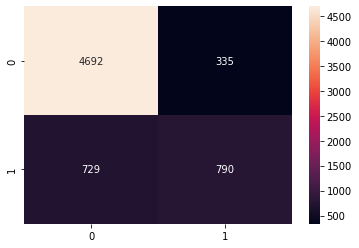

Test Confusion Matrix:



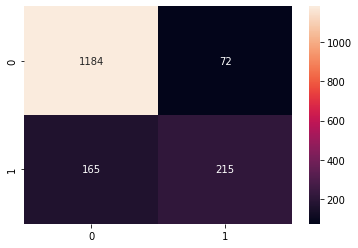

ROC Curve:



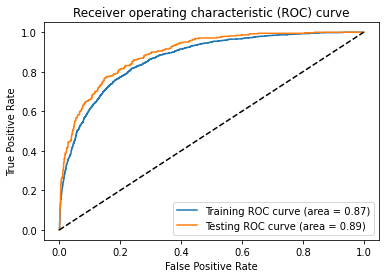

Precision-Recall curve:



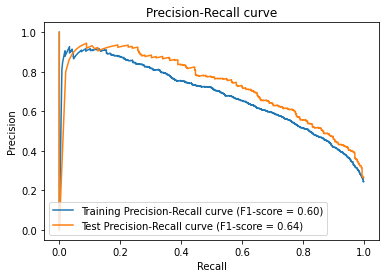

In [35]:
# Use standard scaler to scale the features
scaler=StandardScaler()

# Arrange columns based on their feature importance
top_feat=feat_imp.index.to_list()
X_train2=X_train[top_feat]
X_test2=X_test[top_feat]

# Remove all info regarding the status of Product B account
X_train2=X_train2.drop(['Active','Awaiting Cancel','Frozen'],axis=1)
X_test2=X_test2.drop(['Active','Awaiting Cancel','Frozen'],axis=1)

# Perform Scaling
x_train_scaled = pd.DataFrame(scaler.fit_transform(X_train2.iloc[:,:10]), columns=X_train2.columns[:10])
x_test_scaled = pd.DataFrame(scaler.fit_transform(X_test2.iloc[:,:10]), columns=X_train2.columns[:10])

# Build and fit the logistic regression model
model = LogisticRegression()
model.fit(x_train_scaled,y_train)

# print the model scorecard
score_card(model, x_train_scaled, x_test_scaled, y_train, y_test)